In [75]:
import pandahouse as ph
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

In [37]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [6]:
q = '''
    SELECT 
        count() 
    FROM 
        {db}.ldn_listings 
    LIMIT 10
    '''

In [8]:
# отправляем запрос и записываем результат в пандасовский датафрейм
q_test = ph.read_clickhouse(query=q, connection=connection_default)


In [9]:
q_test

,count()
0,85207


In [13]:
m ='''
SELECT
              room_type,
              toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
FROM
              ldn_listings
ORDER BY
       id ASC
limit 1000
'''

In [15]:
df = ph.read_clickhouse(query=m, connection=connection_default)
df = df.groupby(['room_type'])['price'].quantile(q=0.75).reset_index()
df[df['room_type'] == 'Private room']

,room_type,price
2,Private room,70.0


In [32]:
p = '''
     SELECT DISTINCT  host_id ,
    host_verifications
    FROM ldn_listings
    WHERE experiences_offered != 'none'
    GROUP BY host_id, host_verifications
    limit 1500
    '''

In [33]:
# отправляем запрос и записываем результат в пандасовский датафрейм
ldn_listings_test2 = ph.read_clickhouse(query=p, connection=connection_default)


In [34]:
ldn_listings_test2.host_verifications=ldn_listings_test2.host_verifications\
                                        .apply (lambda x:x\
                                        .strip('[]')\
                                        .replace("'",'')\
                                        .split(', '))

In [35]:
ldn_listings_test2.explode('host_verifications').host_verifications.value_counts().to_frame(name='count')  # переименовываем "A" в "count"

,count
phone,1361
email,1345
reviews,1309
government_id,1196
jumio,1115
offline_government_id,469
work_email,279
facebook,270
selfie,252
identity_manual,227


In [ ]:
df.explode('A').A.value_counts().to_frame(name='count')  # переименовываем "A" в "count"

Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. 

In [57]:
l = '''
 SELECT neighbourhood_cleansed, 
 experiences_offered,
 count(id) as experiences_count
    FROM ldn_listings
      WHERE experiences_offered != 'none'
    GROUP BY neighbourhood_cleansed, 
 experiences_offered
 order by experiences_count DESC
 
    limit 100
    '''


In [58]:
ldn_listings_test3 = ph.read_clickhouse(query=l, connection=connection_default)

In [59]:
forpivot=ldn_listings_test3.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')

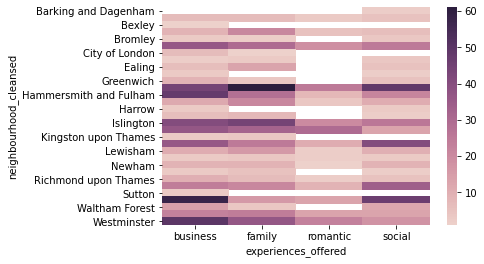

In [60]:
sns.heatmap(forpivot,cmap=sns.cubehelix_palette(as_cmap=True))

In [46]:
ldn_listings_test3 

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


 Выгрузим данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления.


In [76]:
z = '''
 SELECT  room_type,
toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price_corr
    FROM ldn_listings
    WHERE experiences_offered != 'none'
        GROUP BY room_type,price_corr,experiences_offered
    limit 100
    '''

In [77]:
ldn_listings_test4 = ph.read_clickhouse(query=z, connection=connection_default)

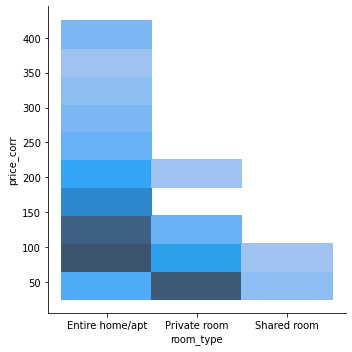

In [86]:
sns.displot(data=ldn_listings_test4, x="price_corr")

In [81]:
np1=np.log(ldn_listings_test4.price_corr)

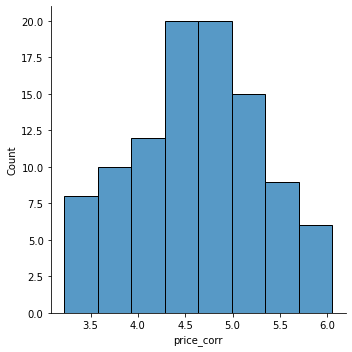

In [83]:
sns.displot(data=np1)